<a href="https://colab.research.google.com/github/martinsphl/MAI5035/blob/main/TAREFA_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAI5035: Task 3 by Paulo Martins, Vitória Barbosa and Isaac Saito

## Problem Definition

The foreign exchange market is a complex, volatile and high-risk system. Independent individuals and companies follow the price of the US dollar to decide on buying/selling of various kinds, such as import contracts, electronics purchases, financial market shares, etc.

**Purpose of the Analysis**

The aim of this analysis is to predict the future price of the dollar for the next day. In this sense, we will offer categories as a target column that represent the future variation of the dollar.

As this is a classification problem, we will use some Machine Learning Algorithms to predict the categories.

The execution time of the project is 5 minutes until the Conclusion section. The knowledge applied in this task came from the MAI5035 course, especially from the Data Analysis and Machine Learning classes, as well as from Task 2.


## Importing Main Libraries

In [1]:
# Main libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
from datetime import datetime

# Preprocess data: normalization and ordinal enconder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

# Classification Algorithms
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

# Ensembles
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# For tuning the code
from sklearn.pipeline import Pipeline

# For Model Metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Avoiding warning messages
import warnings
warnings.filterwarnings('ignore')

# Setting a global seed
np.random.seed(7)

## Data Gathering

We created a github public repository to upload the csv dataset and do software versioning. From github public url, we load the data into a pandas dataframe.

**Data Description:**

US Dollar Index dataset ([Available Here](https://www.kaggle.com/datasets/balabaskar/us-dollar-index-data))

1.   Date: Date of observation (time variable in the format Month DD, YYYY)
2.   Price: Dollar index at market close (continuous and positive variable)
3.   Open: Dollar index at market opening (continuous and positive variable)
4.  High: Highest index value observed on the day (continuous, positive variable)
5. Low: Lowest index value observed on the day (continuous, positive variable)
6. Change %: Change in the dollar index compared to the previous day (continuous variable in percent)

In [2]:
runtime_start = datetime.now()
# Defining the url of each dataset
dataset_url = 'https://raw.githubusercontent.com/martinsphl/MAI5035/refs/heads/main/US%20Dollar%20Index%20Historical%20Data.csv'

# Creating pandas dataframe from each dataset
df_dollar = pd.read_csv(dataset_url, names=['date', 'last_price', 'first_price', 'biggest_price', 'lowest_price', 'perc_variation'], skiprows=1, delimiter=',')

# Remove '%'symbol from pec_variation column
df_dollar['perc_variation'] = df_dollar['perc_variation'].str[:-1]
df_dollar['perc_variation'] = df_dollar['perc_variation'].astype(float)

# Show some rows
print(df_dollar.head(5).to_markdown())

|    | date         |   last_price |   first_price |   biggest_price |   lowest_price |   perc_variation |
|---:|:-------------|-------------:|--------------:|----------------:|---------------:|-----------------:|
|  0 | Jan 02, 2001 |       108.77 |        109.33 |          109.65 |         108.64 |            -0.72 |
|  1 | Jan 03, 2001 |       110.17 |        108.59 |          110.34 |         108.09 |             1.29 |
|  2 | Jan 04, 2001 |       108.81 |        110.3  |          110.4  |         108.51 |            -1.23 |
|  3 | Jan 05, 2001 |       108.42 |        108.64 |          109.31 |         108.26 |            -0.36 |
|  4 | Jan 08, 2001 |       108.86 |        108.33 |          109.19 |         108.23 |             0.41 |


As you can see, the previous dataset there are few features. So we decided to enrich this one using other dataframe, which was filtered for the main 6 currencies based on Euro price:

**Data Description:**

Daily Exchange Rates per Euro ([Available Here](https://www.kaggle.com/datasets/lsind18/euro-exchange-daily-rates-19992020))

1.   Period: Date of observation (time variable in YYYY-MM-DD format)
2.   US dollar: Value of 1 euro in US dollars (continuous and positive variable)
3.   Japanese Yen: Value of 1 euro in Japanese Yen (continuous and positive variable)
4.   Australian dollar: Value of 1 euro in Australian dollar (continuous and positive variable)
5.   Canadian dollar: Value of 1 euro in Canadian dollars (continuous and positive variable)
6.   Swiss franc : Value of 1 euro in Swiss franc (continuous positive variable)
7.   UK pound sterling: Value of 1 euro in pound sterling (continuous and positive variable)
8. Other columns: Value of 1 euro in other currencies (continuous and positive variable). Other currencies are outside the scope of this analysis as they have little impact on the dollar rate, according to the business.

In [3]:
# Defining the url of each dataset
dataset_url = 'https://raw.githubusercontent.com/martinsphl/MAI5035/refs/heads/main/euro-daily-hist_1999_2022.csv'

# Creating pandas dataframe
columns = ['date','australian_dollar','bulgarian_lev','brazilian_real','canadian_dollar','swiss_franc','chinese_yuan',	'cypriot_pound','czech_koruna','danish_krone','estonian_kroon','uk_pound',	'greek_drachma','hk_dollar','croatian_kuna','hungarian_forint',	'indonesian_rupiah','israeli_shekel','indian_rupee','iceland_krona','japanese_yen','korean_won','lithuanian_litas','latvian_lats','maltese_lira','mexican_peso','malaysian_ringgit','norwegian_krone','new_zealand_dollar','philippine_peso','polish_zloty','romanian_leu','russian_rouble','swedish_krona','singapore_dollar','slovenian_tolar','slovak_koruna','thai_baht','turkish_lira','us_dollar','south_african_rand']
df_euro = pd.read_csv(dataset_url, names=columns, skiprows=1, delimiter=',')

print(df_euro.head(5).to_markdown())

|    | date       |   australian_dollar |   bulgarian_lev |   brazilian_real |   canadian_dollar |   swiss_franc |   chinese_yuan |   cypriot_pound |   czech_koruna |   danish_krone |   estonian_kroon |   uk_pound |   greek_drachma |   hk_dollar |   croatian_kuna |   hungarian_forint |   indonesian_rupiah |   israeli_shekel |   indian_rupee |   iceland_krona |   japanese_yen |   korean_won |   lithuanian_litas |   latvian_lats |   maltese_lira |   mexican_peso |   malaysian_ringgit |   norwegian_krone |   new_zealand_dollar |   philippine_peso |   polish_zloty |   romanian_leu |   russian_rouble |   swedish_krona |   singapore_dollar |   slovenian_tolar |   slovak_koruna |   thai_baht |   turkish_lira |   us_dollar |   south_african_rand |
|---:|:-----------|--------------------:|----------------:|-----------------:|------------------:|--------------:|---------------:|----------------:|---------------:|---------------:|-----------------:|-----------:|----------------:|------------:|---

In [4]:
# Merge both dataframe
df_euro['date'] = pd.to_datetime(df_euro['date']).dt.strftime('%Y-%m-%d')
df_dollar['date'] = pd.to_datetime(df_dollar['date']).dt.strftime('%Y-%m-%d')
df_enriched = pd.merge(df_dollar, df_euro, on=['date'], how='inner')
df_euro = None
df_dollar = None

# Be sure there are only numeric values into the columns
columns = df_enriched.columns.to_list()
columns.remove('date')
list_date = df_enriched['date']
df_enriched = df_enriched.loc[:, columns].apply(pd.to_numeric, errors='coerce')
df_enriched['date'] = list_date

## Data Exploration
On this stage, we will get knowlodge on data. So, we'll check the type of columns and how many null values there are; since this point, all next exploratory analysis will be under numerics columns: check descriptive statistics, density distribution and outliers occurrences by IQR.

**Feature Selection**

At this point, we'll check the set of uncorrelated features and filter the clean data set only for these features.

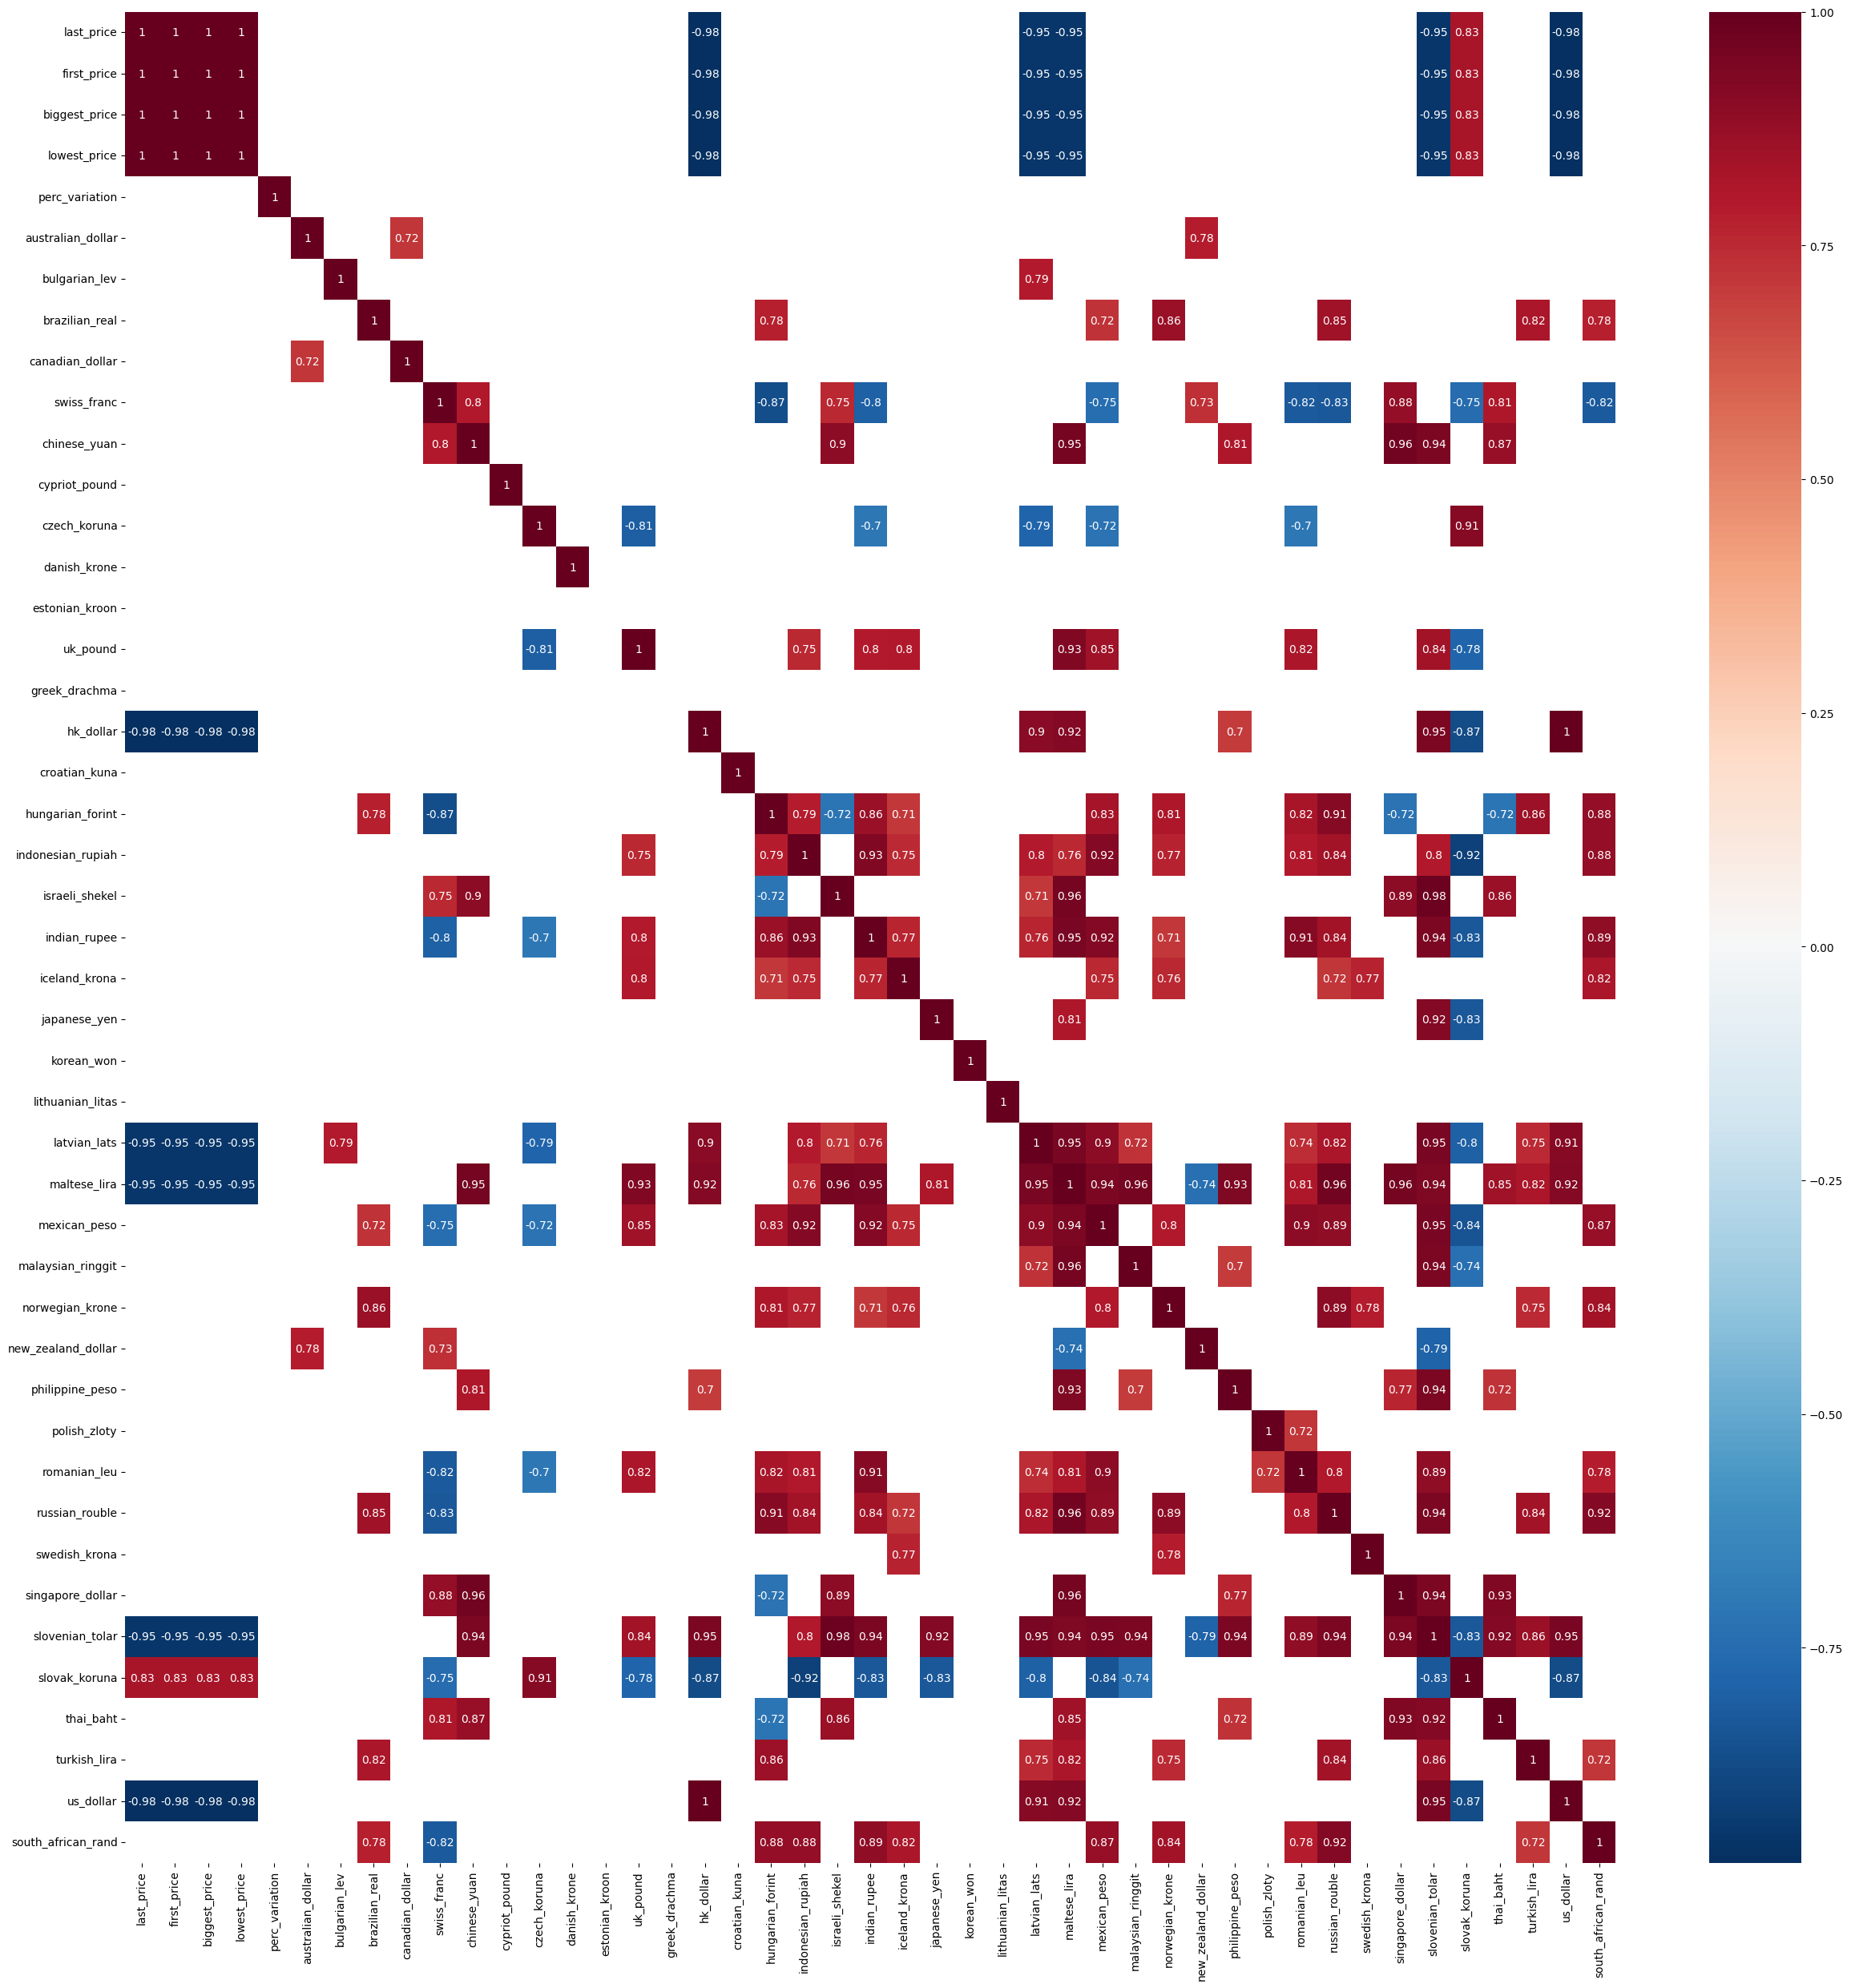

In [5]:
# Correlation matrix for strongly correlated positive or negative values
plt.figure(figsize=(30, 30))
correlation_matrix = df_enriched.iloc[:, :-1].corr()
mask = (correlation_matrix > 0.70) | (correlation_matrix < -0.70)
sns.heatmap(correlation_matrix[mask], annot=True, cmap='RdBu_r')
plt.show()

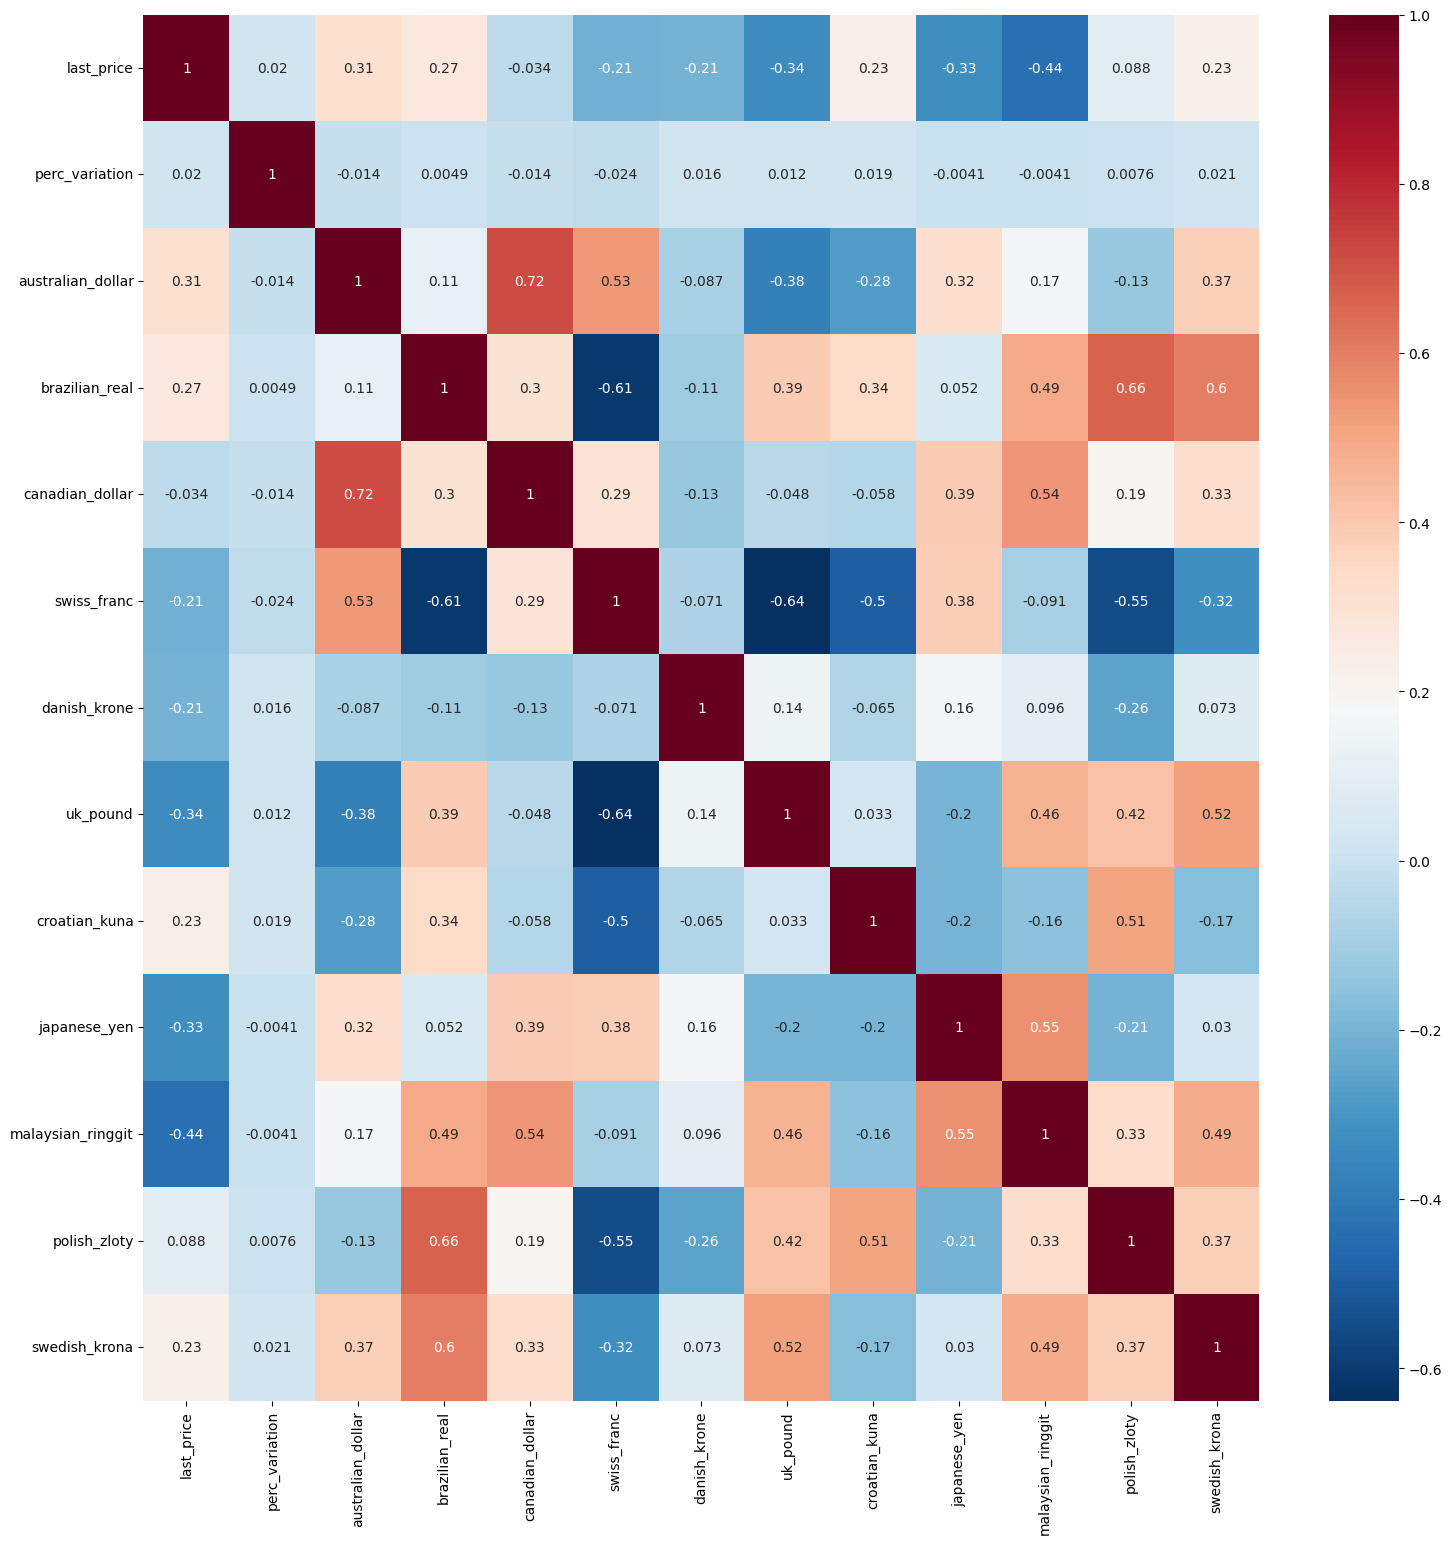

In [6]:
# List all correlacted features
lst_features = df_enriched.columns.to_list()
lst_correlated_features = ['first_price', 'biggest_price', 'lowest_price', 'slovenian_tolar', 'slovak_koruna', 'us_dollar', 'turkish_lira', 'south_african_rand', 'singapore_dollar', 'thai_baht', 'hungarian_forint']
lst_correlated_features += ['latvian_lats', 'mexican_peso', 'norwegian_krone', 'new_zealand_dollar', 'russian_rouble', 'hk_dollar', 'maltese_lira', 'czech_koruna', 'indonesian_rupiah', 'indian_rupee', 'iceland_krona', 'estonian_kroon', 'greek_drachma']
lst_correlated_features += ['chinese_yuan', 'romanian_leu', 'cypriot_pound', 'lithuanian_litas', 'bulgarian_lev', 'philippine_peso', 'israeli_shekel', 'korean_won']

# Removing correlated features
for col in lst_correlated_features:
  lst_features.remove(col)

# Show the correlation between the features sample
df_filtered = df_enriched.loc[:, lst_features]
plt.figure(figsize=(18, 18))
sns.heatmap(df_filtered.iloc[:, :-1].corr(), annot=True, cmap='RdBu_r')
plt.show()

Although the Canadian and Austrailia dollar have a correlation of just over 70%, we know from business knowledge that these currencies are important for the price of the US dollar, so we decided to keep them.

Total of rows 5569


<Axes: >

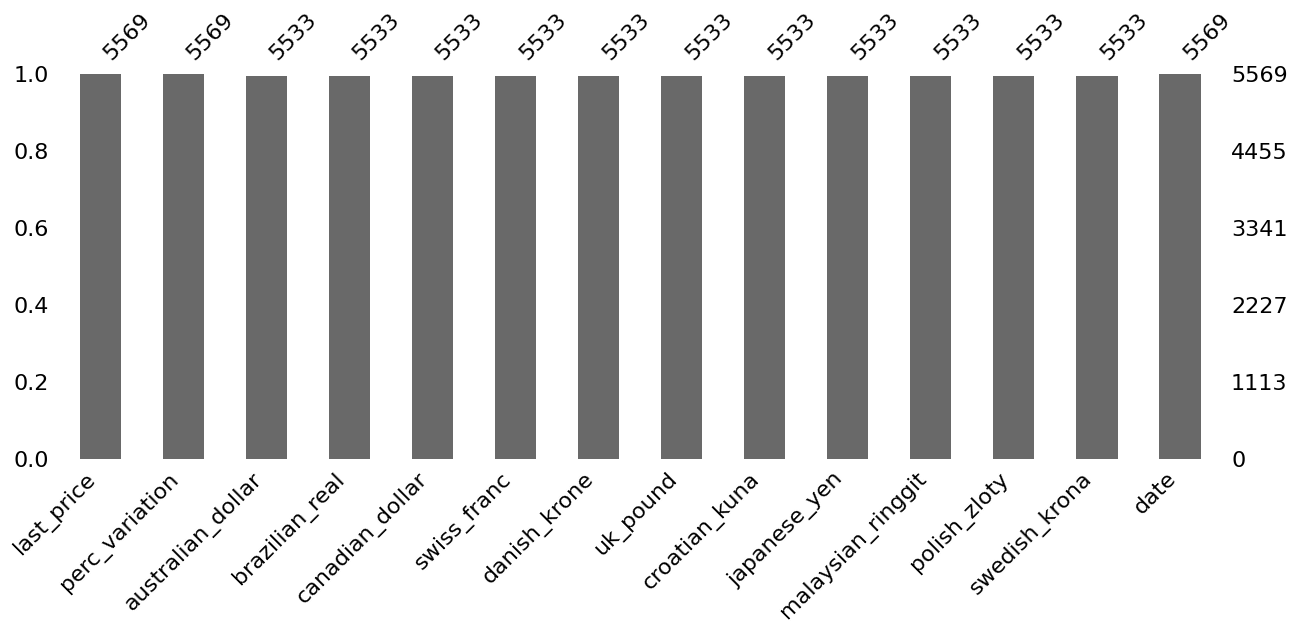

In [7]:
# Check how many Missing Values there are
print(f"Total of rows {df_filtered.shape[0]}")
ms.bar(df_filtered, figsize=(15,5))

In [8]:
# Checking the Descriptive Statistics of numerics columns
print(df_filtered.describe())

        last_price  perc_variation  australian_dollar  brazilian_real  \
count  5569.000000     5569.000000        5533.000000     5533.000000   
mean     90.478107        0.001219           1.572534        3.463612   
std      10.708799        0.485459           0.155623        1.172879   
min      71.330000       -3.020000           1.163900        1.799400   
25%      81.430000       -0.280000           1.465700        2.595800   
50%      89.940000        0.000000           1.594300        3.167900   
75%      96.930000        0.270000           1.673100        3.961500   
max     120.900000        2.560000           2.073500        6.955300   

       canadian_dollar  swiss_franc  danish_krone     uk_pound  croatian_kuna  \
count      5533.000000  5533.000000   5533.000000  5533.000000    5533.000000   
mean          1.465625     1.314896      7.448481     0.787610       7.458325   
std           0.095128     0.209298      0.011386     0.093446       0.124425   
min           1.21

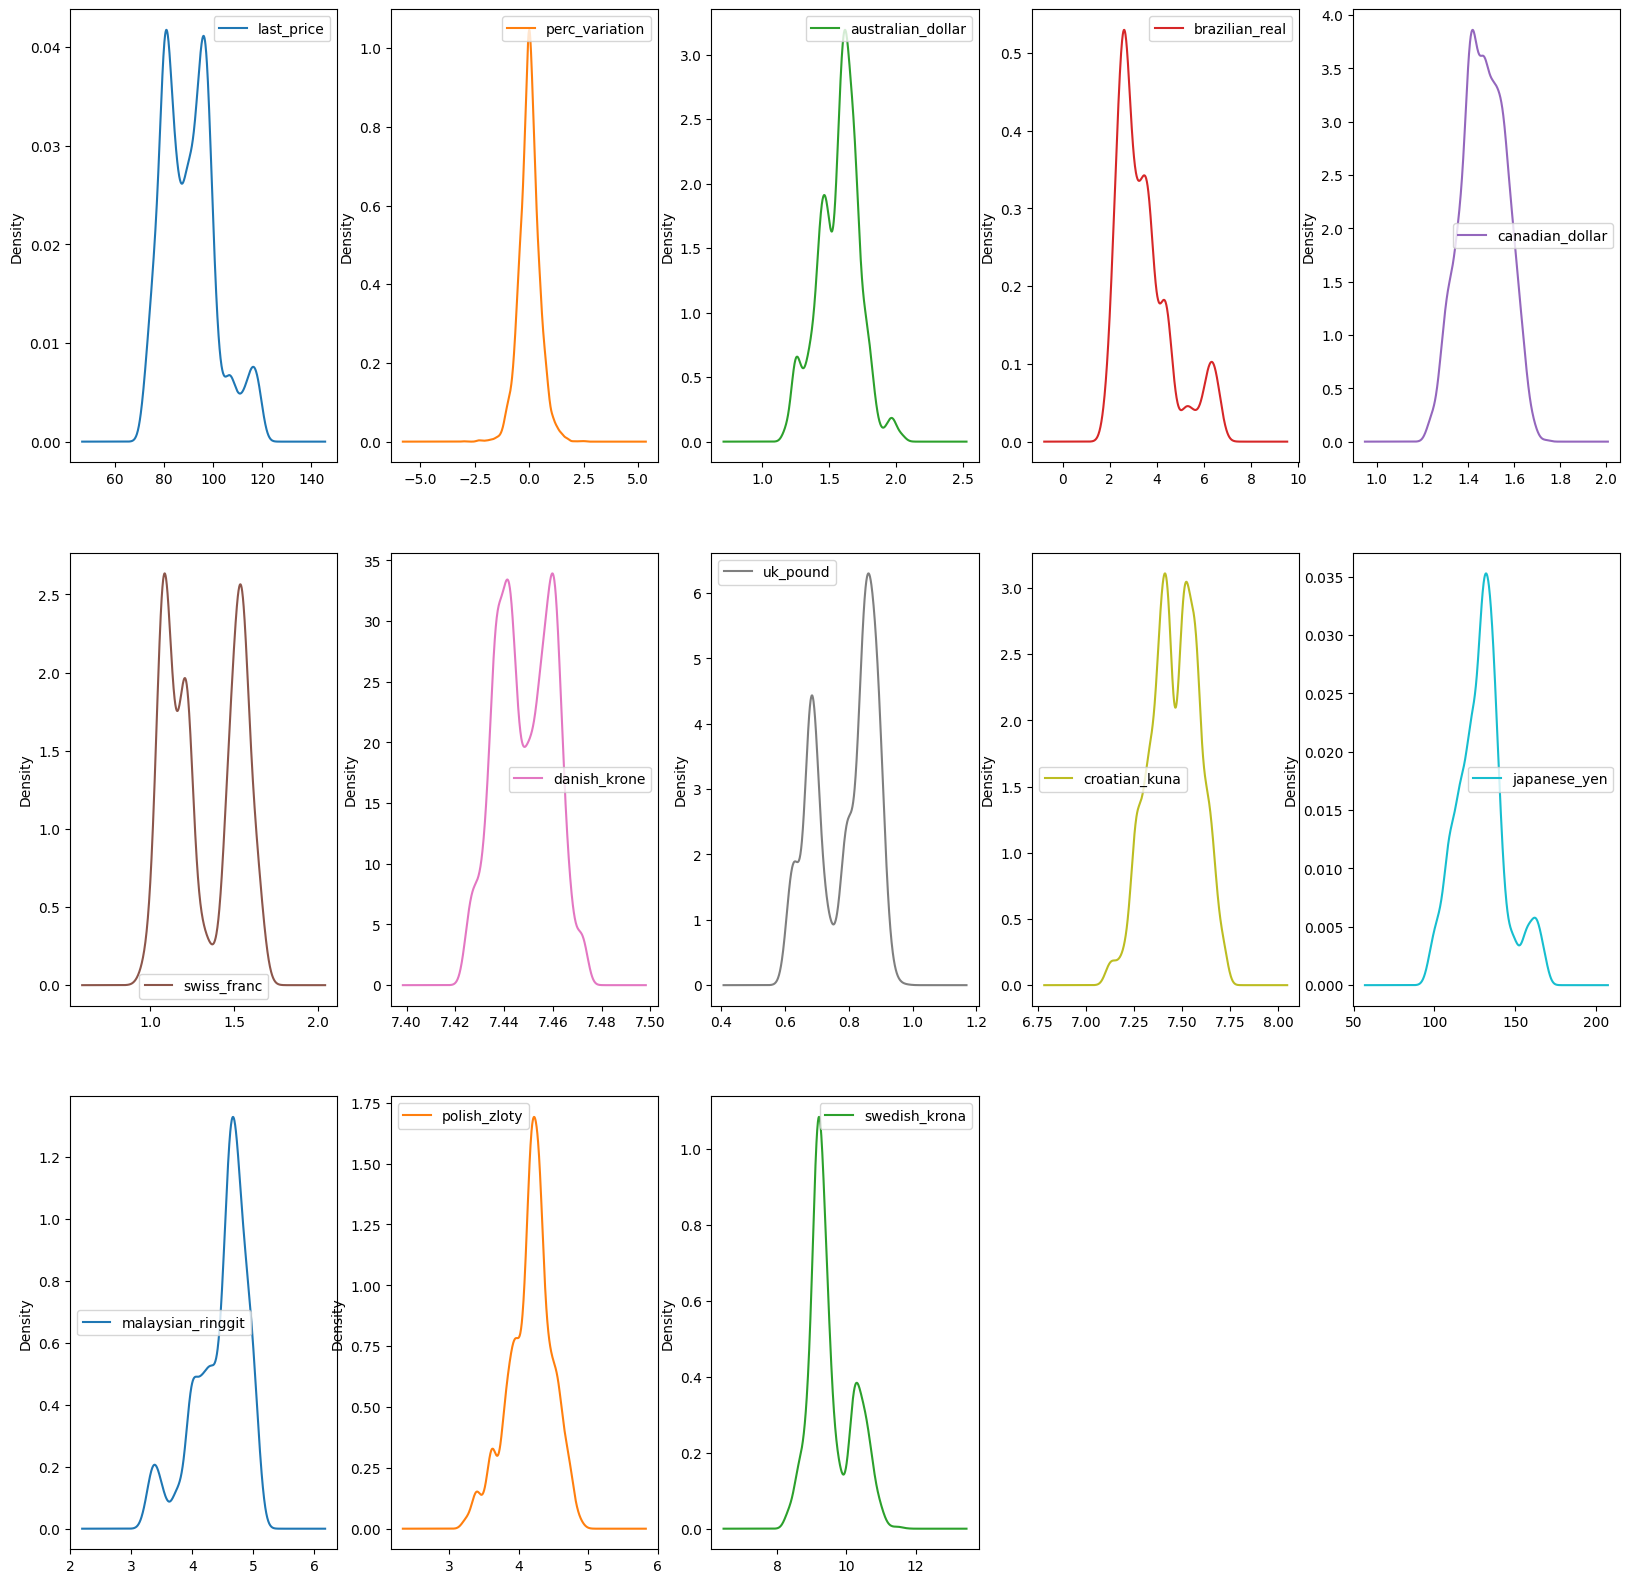

In [9]:
# Now let's check the density distribution of numeric columns
df_filtered.plot(kind = 'density', subplots = True, layout = (3,5), sharex = False, figsize = (20,20))
plt.show()


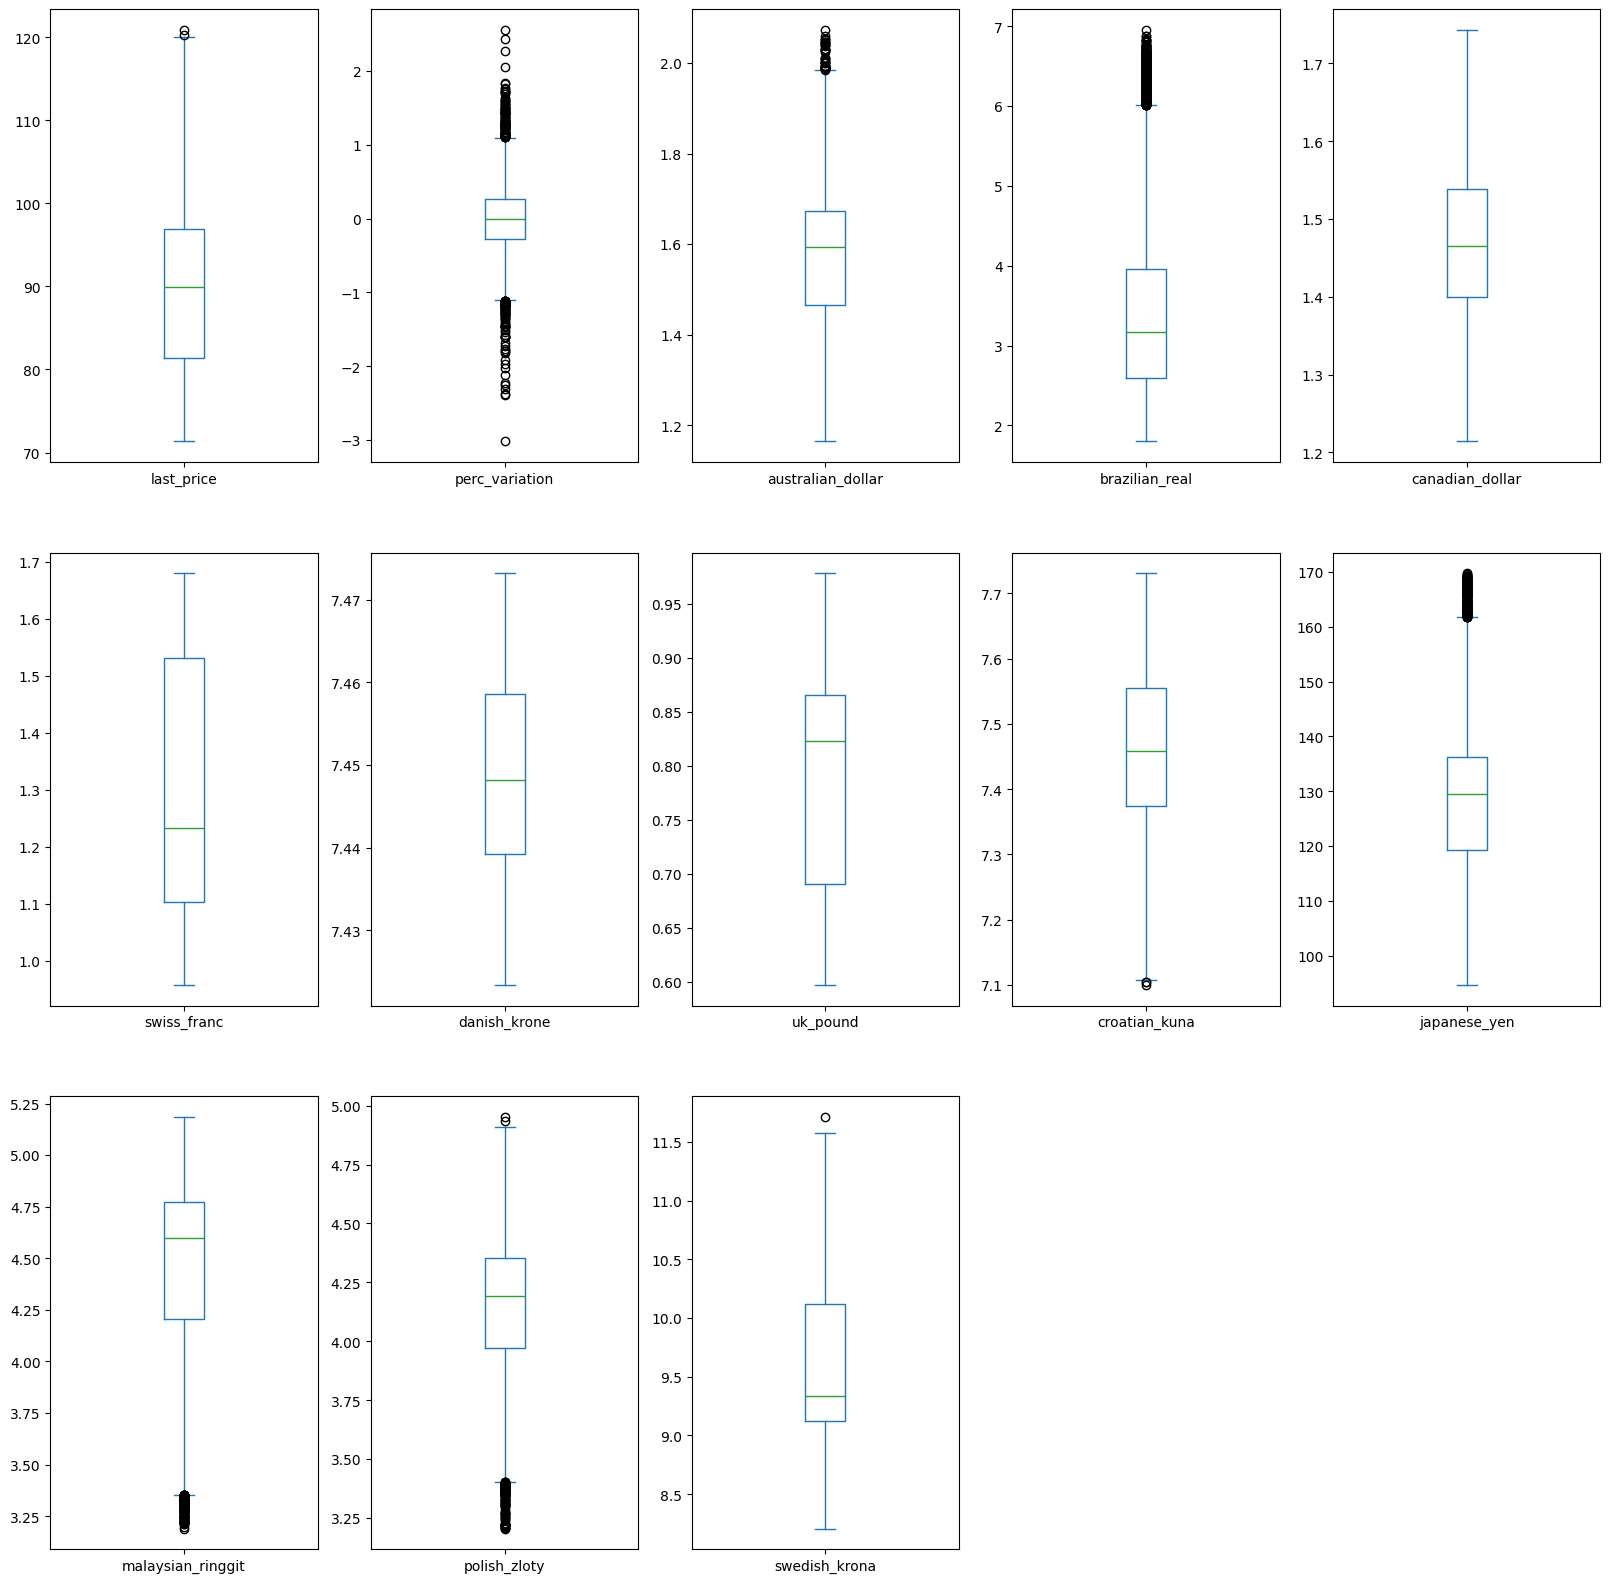

In [10]:
# Finally verifying if there is any outlier values based on IQR technique
df_filtered.plot(kind = 'box', subplots = True, layout = (3,5), sharex = False, sharey = False, figsize = (20,20))
plt.show()

## Data Cleansing up

This chapter is to preprocess the data before applying any machine learning algorithm. Therefore, we will detect outlier and null values to replace those for estimated value.

### Replace outliers

Outliers increase the noise in the data. It is a difficult task to find out what the correct value of the signal would be. Often, this task is impossible to discover.

The data has few outliers detected by the IQR method, maybe because both datasets came from Kaggle. Just to be sure, let's deal with these outliers values using:
 1. perc_variation: the values of all columns will be recalculated based on the documentation
 2. other columns: replace for NaN and on the next step it'll receive the average between the day before and the day after

We know that the currency market is volatile and perhaps the discrepant values identified in the perc_variation column are a reflection of the market. Just for verification purposes, we will recalculate all the values in this column according to the official documentation

In [11]:
df_cleaned = df_filtered.copy()
df_cleaned['calculated_perc_variation'] = 100 * ((df_cleaned['last_price'] / df_cleaned['last_price'].shift()) - 1)
df_cleaned.loc[0, 'calculated_perc_variation'] = df_cleaned.loc[0, 'perc_variation']
print(df_cleaned[['perc_variation', 'calculated_perc_variation']].describe())

       perc_variation  calculated_perc_variation
count     5569.000000                5569.000000
mean         0.001219                   0.001271
std          0.485459                   0.485685
min         -3.020000                  -3.018085
25%         -0.280000                  -0.275716
50%          0.000000                   0.000000
75%          0.270000                   0.273335
max          2.560000                   2.555828


In [12]:
# Just deciding on one of the two
df_cleaned['perc_variation'] = df_cleaned['calculated_perc_variation']
df_cleaned.drop(columns=['calculated_perc_variation'], axis=1, inplace=True)

Based on the descriptive statistics above, we can see that the change was not very significant. In general, the data has changed from the third decimal place. Since we've to decide on one of the two columns, we'll keep the value of calculated_perc_variation by replacing the values in perc_variation.

For currency there are some outliers, we'll replace the outlier values for NaN. On the next step (replace missing values), these NaN will be replaced.

In [13]:
list_indices = [0, 2, 3, 8, 9, 10, 11, 12]
print("Removing outlier values: ")
for i in list_indices:
    print(f"\tStarting with {df_cleaned.columns[i]}")
    # IQR Range mask
    q3 = df_cleaned.iloc[:, i].quantile(0.75)
    q1 = df_cleaned.iloc[:, i].quantile(0.25)
    iqr = q3 - q1
    iqr_sup_lim = df_cleaned.iloc[:, i] > (q3 + 1.5 * iqr) # value close to q3
    iqr_inf_lim = df_cleaned.iloc[:, i] < (q1 - 1.5 * iqr) # value close to q1

    # Main mask
    mask = iqr_sup_lim | iqr_inf_lim
    df_cleaned.iloc[mask, i] = np.nan # replace by Not a Number value

Removing outlier values: 
	Starting with last_price
	Starting with australian_dollar
	Starting with brazilian_real
	Starting with croatian_kuna
	Starting with japanese_yen
	Starting with malaysian_ringgit
	Starting with polish_zloty
	Starting with swedish_krona


### Replace Missing Values

There are only missing values in the currency columns. So we'll fill in these columns by calculating the average between the previous and next values of the missing value.

In [14]:
# Get columns name from dataframe
lst_index_column = [0] + list(range(2, 14))
for col in df_cleaned.iloc[:, lst_index_column].columns:
  mask = df_cleaned.loc[:, col].isna()
  print(f"Filling in {col} column")
  while mask.any():
    df_cleaned.loc[mask, col] = df_cleaned[col].shift()
    mask = df_cleaned.loc[:, col].isna()

Filling in last_price column
Filling in australian_dollar column
Filling in brazilian_real column
Filling in canadian_dollar column
Filling in swiss_franc column
Filling in danish_krone column
Filling in uk_pound column
Filling in croatian_kuna column
Filling in japanese_yen column
Filling in malaysian_ringgit column
Filling in polish_zloty column
Filling in swedish_krona column
Filling in date column


### Double-checking on cleaned dataframe
Finally let's check if all missing values and outliers were removed.

<Axes: >

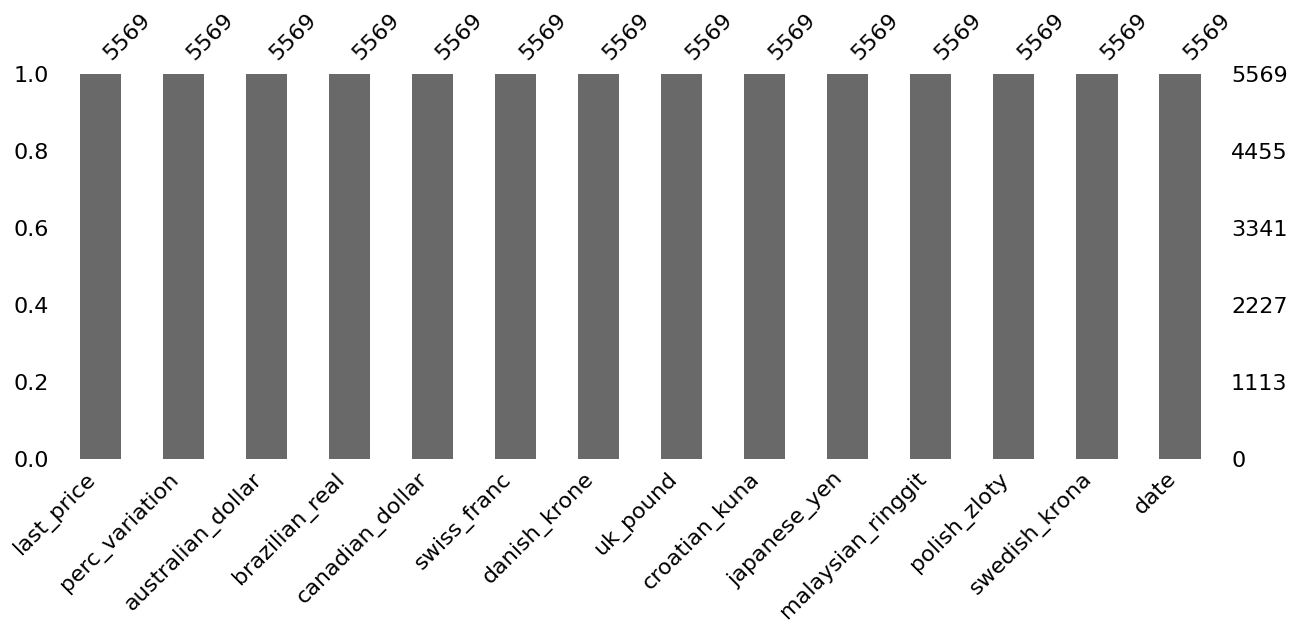

In [15]:
ms.bar(df_cleaned, figsize=(15,5))

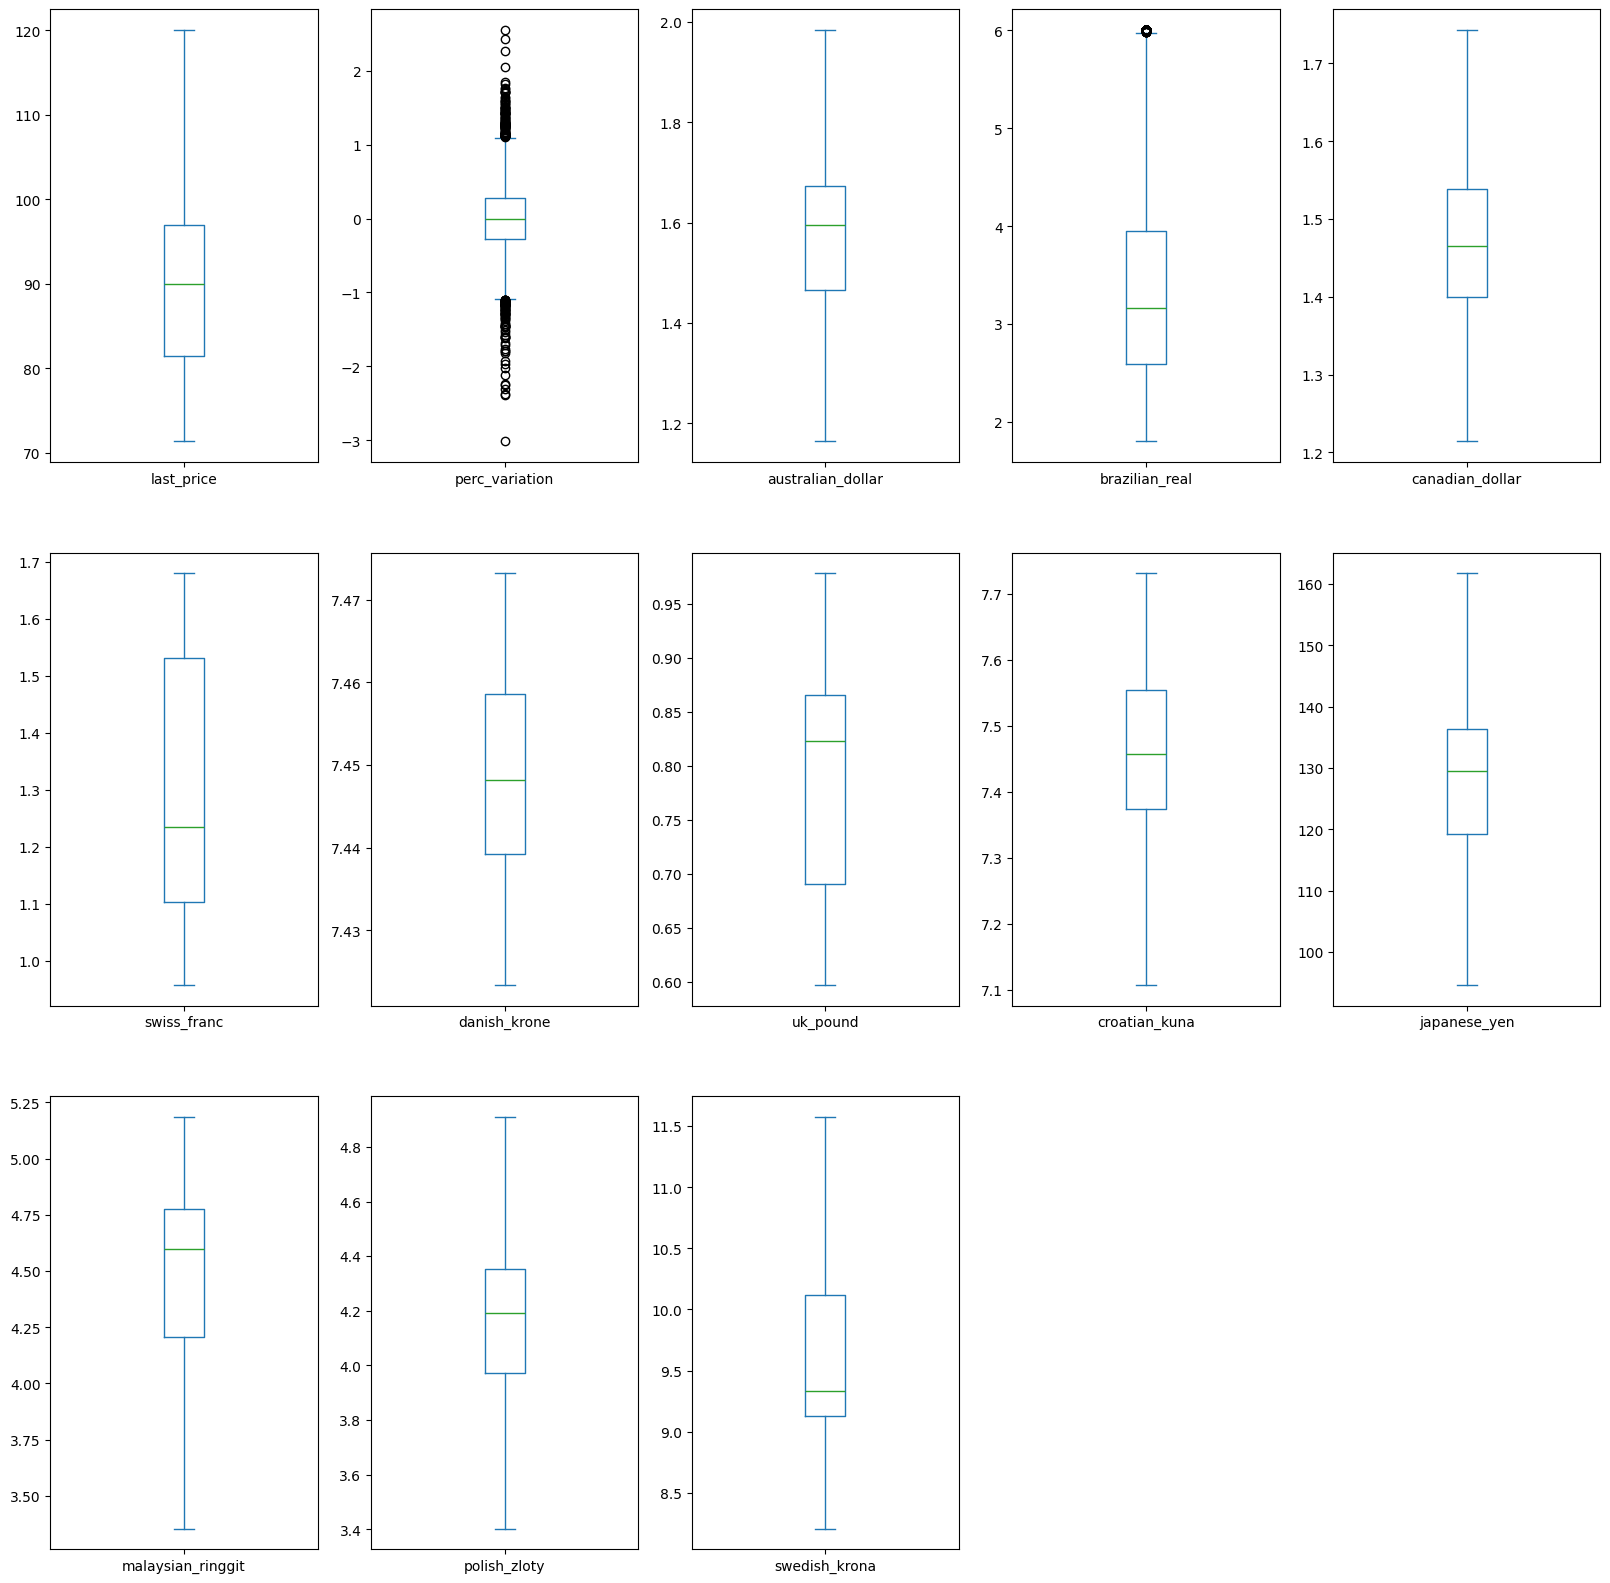

In [16]:
# Finally verifying if there is any outlier values based on IQR technique
df_cleaned.plot(kind = 'box', subplots = True, layout = (3,5), sharex = False, sharey = False, figsize = (20,20))
plt.show()

## Feature Engineering

From this point, we'll create additional features to increase the prediction. As this problem is time series one, the sequency is relevante and then we'll create column for year, month, day and day of week.

Also we'll create a moving-average column over 28 days and catch the previous last price in 7 days.

At last we'll add a new one columns: perc_future_variation. This one will be used to define the categories of this problem (target-column)

In [17]:
# Ordering the data
df_cleaned.sort_values(by=['date'], ascending=True)

# Create 3 new features
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])
df_cleaned['day'] = df_cleaned['date'].dt.day
df_cleaned['month'] = df_cleaned['date'].dt.month
df_cleaned['year'] = df_cleaned['date'].dt.year
df_cleaned['day_of_week'] = df_cleaned['date'].dt.weekday
df_cleaned.drop(columns=['date'], axis=1, inplace=True)

# Moving-average of last 28 days and last price of previous 7 days
df_cleaned['mov_avg_28_last_price'] = df_cleaned['last_price'].rolling(window=28, min_periods=28).mean()
df_cleaned['last_price_prev_7_days'] = df_cleaned['last_price'].shift(7)

# Perc. Future Variation]
df_cleaned['perc_future_variation'] = 100 * ((df_cleaned['last_price'].shift(-1) / df_cleaned['last_price']) - 1)

# Remove rows that are Missing Values from moving average, previous 7 days and perc future variation
df_cleaned = df_cleaned.dropna()

In [18]:
# Show the output
print(df_cleaned.head(5).to_markdown())

|    |   last_price |   perc_variation |   australian_dollar |   brazilian_real |   canadian_dollar |   swiss_franc |   danish_krone |   uk_pound |   croatian_kuna |   japanese_yen |   malaysian_ringgit |   polish_zloty |   swedish_krona |   day |   month |   year |   day_of_week |   mov_avg_28_last_price |   last_price_prev_7_days |   perc_future_variation |
|---:|-------------:|-----------------:|--------------------:|-----------------:|------------------:|--------------:|---------------:|-----------:|----------------:|---------------:|--------------------:|---------------:|----------------:|------:|--------:|-------:|--------------:|------------------------:|-------------------------:|------------------------:|
| 27 |       112.06 |        1.0551    |              1.698  |           1.8403 |            1.3916 |        1.5312 |         7.4613 |     0.6355 |          7.7105 |         106.97 |              3.504  |         3.7696 |          8.8795 |     8 |       2 |   2001 |          

### Define target column

At this point, we only have a clean dataframe from kaggle and did some feature engineering. Now we'll decide for 3 categories that explain the percentage of future variation. To find out the threshould, we'll plot a histogram chart over that column.

<Axes: >

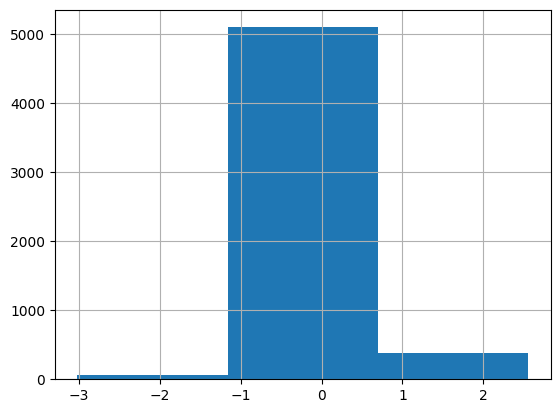

In [19]:
# Find out the classes of problems
df_cleaned.perc_future_variation.hist(bins=3)

Based on histogram, the 3 categories are:


*   A: Less Equal to -1
*   B: Greater than -1 and less than 1
*   C: Greater equal to 1





In [20]:
# Creating the conditions for each category and then apply it for the column value
choices = ['A', 'B', 'C']
conditions = [
    df_cleaned['perc_future_variation'].le(-1),
    (df_cleaned['perc_future_variation'].gt(-1)) & (df_cleaned['perc_future_variation'].lt(1)),
    (df_cleaned['perc_future_variation'].ge(1)),
]

df_cleaned['category'] = np.select(conditions, choices, default=np.nan)

# Once the category column was created, the perc_future_variation must be deleted
df_cleaned.drop(columns=['perc_future_variation'], axis=1, inplace=True)

### Feature Normalization

To increase the algorithms peformance, we'll normalize all features column using MinMaxScaler. The output will be values in the range 0 and 1.

In [21]:
df_normalized = df_cleaned.copy()

scaler = MinMaxScaler()
# Avoiding target column
for i in range(0,df_normalized.shape[1] - 1):
  df_normalized.iloc[:, i] = scaler.fit_transform(df_normalized.iloc[:, [i]])

At this point, we expect that there are only uncorrelated variables to feed machine learning algoritms. The unique exceptions are moving average and last price of previous 7 days, both were calculated based on last_price.

We decided to keep those because this problem is based on time series and then it's relevante to add some chronological data to the present datapoint.

## Modeling and Interference

In this phase, we're going to submit the pre-processed dataframe to various machine learning algorithms and compare the results. To do this, we will carry out the following steps: check the linearity of the data, choose algorithms, separate training and test data, build models, train models with normalized data and optimize the hyperparameters of the best performing model.

### Checking Data Linearity

The choice of a machine learning algorithm depends on factors such as the nature of the problem, the type of data and the relationship between the independent and dependent variables (linearity).

At this point in the research, we already know that the problem is a financial time series of high complexity and volatility, that the data is numerical (discrete and continuous) and is free of null values. As for the linearity of the data, to find out whether the problem is linear or not, we can analyze the graph of the perc_future_variation of dolar over the years:

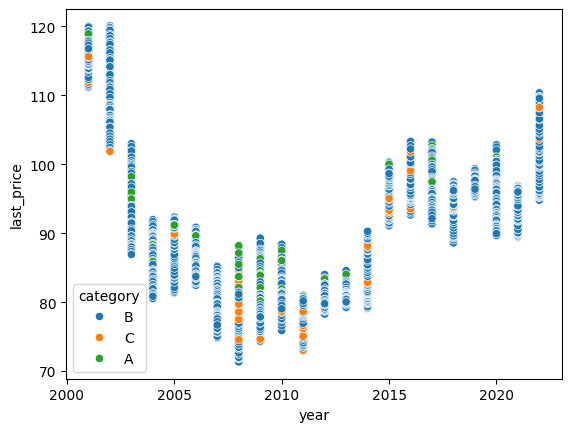

In [22]:
df_cleaned.sort_values(by=['year', 'month', 'day'], ascending=True)
sns.scatterplot(data=df_cleaned, x="year", y="last_price", hue="category")
plt.show()

As you can see from interpreting the graphs, the separation of the categories is a non-linear problem, as a straight line is insufficient to segment the classes properly.

### Choosing Algorithms

At this stage we will identify the algorithms that can be useful in modeling the problem. As we want to deduce the future price of bitcoin from historical data, we will use supervised algorithms for classification:

> **Decision Tree (CART):** This is an algorithm capable of dealing with non-linear relationships between the input variables and the output variable, robust to the occurrence of outliers and easy to interpret.

>**Support Vector Machine (SVC):** Can deal with non-linear problems, the algorithm is robust to the occurrence of outliers in the data and efficient in high-dimensional spaces

> **K-NN Regressor:** Suitable for complex relationships between the input variables and the output variable, the algorithm is robust to non-linear problems and easy to interpret.

> **Softmax Logistic Regression:** can be easily regularized to avoid overfitting and improve the generalization of the model, is a robust and widely used approach for multiclass classification problems, and is relatively simple to implement and interpret.

> **VotingClassifier:** A committee technique that allows different classification algorithms to be combined into a single solution and tends to be more robust than any single classifier.

> **BaggingClassifier:** The main idea behind the algorithm is to create multiple samples (called bootstrap samples) from the original training set and train a different classifier on each of these samples.

 ### Separate Train, Test and Validation Data

 In order to train and test the models, we will separate the data into two groups: 80% for training and 20% for testing. To reduce bias in the data and make it easier to identify overfitting and/or underfitting, we will apply the cross-validation technique.

In [23]:
# Stratified Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(df_normalized.iloc[:, :-1], df_normalized.iloc[:, -1], test_size=0.2, random_state=7)

# Now getting a validation dataframe from X_test and y_test: testing (60%) and Validation (40%)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.4, random_state=7)

# Using stratified cross-validation to reduce bias, overfitting and eliminate the possibility of unbalanced classes... with 10 folds to be more robust
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=7)

categories = df_cleaned.iloc[:, -1].unique()
n_categories = len(categories[0])

### Building Models
At this point we have the data available to train the models. Next we will instantiate each model and then display the Boxplot.

In [24]:
start=datetime.now()
# Creating the models and adding them to the list
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('LR', LogisticRegression()))

# Creating the VotingClassifier
bases = []
model1 = LogisticRegression()
bases.append(('lr', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Creating the ensembles of classifiers
models.append(('Bagging', BaggingClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))
models.append(('Ada', AdaBoostClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('Voting', VotingClassifier(bases)))

msg = ''
results = []
names = []

# Iteratively training each model
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  #Show MSE, MSE std and RMSE of 10 folds
  msg += '\t%s: %f (%f).\n' % (name, cv_results.mean(), cv_results.std())

print(msg)
print(f'\nRuntime: {round((datetime.now()-start).total_seconds()/60,2)} minutes')

	KNN: 0.954424 (0.001935).
	CART: 0.915158 (0.011191).
	SVM: 0.955777 (0.001090).
	LR: 0.955777 (0.001090).
	Bagging: 0.949232 (0.003547).
	RF: 0.954197 (0.001758).
	ET: 0.952842 (0.003276).
	Ada: 0.954196 (0.002498).
	GB: 0.951037 (0.002497).
	Voting: 0.955777 (0.001090).


Runtime: 3.27 minutes


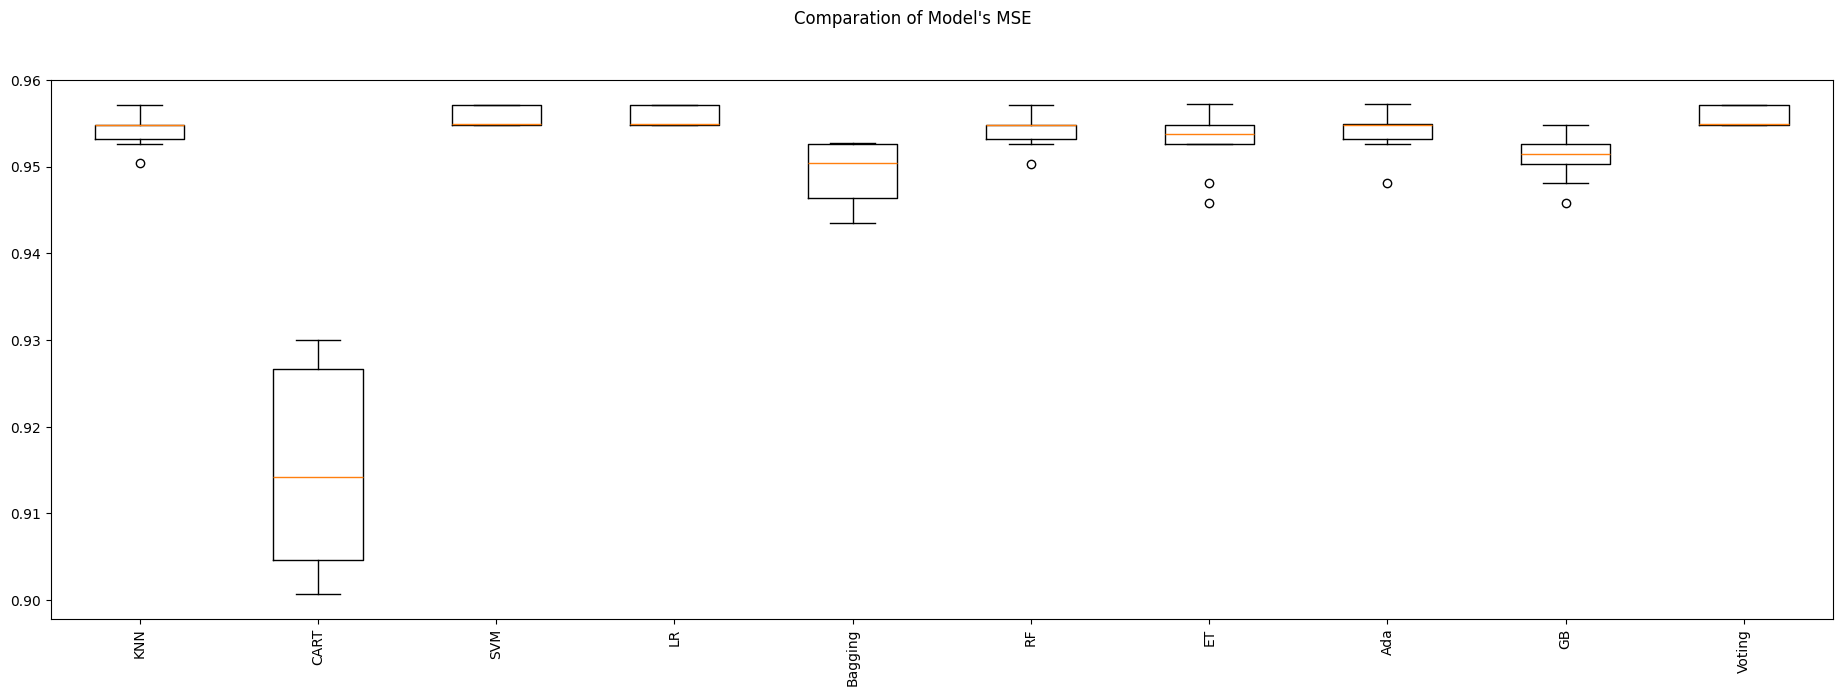

In [25]:
# Benchmarking between the models
fig, ax = plt.subplots(figsize=(23,7))
fig.suptitle("Comparation of Model's MSE")
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

As you can see, three-classifiers tie with the best score: Support Vector Machine, Logistic Regression and Voting Ensemble. From now on, we will keep only these models on the pipeline.

### Optimize Hyperparameters of the Best Performing Models

In this step, we'll do a fine-tuning for each selected classifier and run the algorithm again with the validation data.


In [26]:
start=datetime.now()
print("SVM Classifier:")

# Pipeline with only the classifier to apply on original data
pipeline = Pipeline([('SVM', SVC())])

# Define the hyperparameters
param_grid = {
    'SVM__C': [0.1, 1, 10, 100],               # Regularization parameter
    'SVM__kernel': ['linear', 'rbf', 'poly'],  # Different kernels
    'SVM__gamma': ['scale', 'auto', 0.1, 1]    # Kernel coefficient
}

# Create the gridSearch with pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold)

# Looking for the best hyperparameters
grid_search.fit(X_validation, y_validation)

# Show the best results
print('\tThe Best Result: %f and its parameters %s' % (grid_search.best_score_, grid_search.best_params_))
print(f'\tRuntime: {round((datetime.now()-start).total_seconds()/60,2)} minute')

SVM Classifier:
	The Best Result: 0.941515 and its parameters {'SVM__C': 0.1, 'SVM__gamma': 'scale', 'SVM__kernel': 'linear'}
	Runtime: 0.14 minute


In [27]:
start=datetime.now()
print("LR Classifier:")

# Pipeline with only the classifier to apply on original data
pipeline = Pipeline([('LR', LogisticRegression(multi_class='multinomial'))])

# Define the hyperparameters
param_grid = {
    'LR__C': [0.1, 1, 10, 100],                     # Regularization strength
    'LR__solver': ['newton-cg', 'lbfgs', 'saga'],   # Solvers
    'LR__max_iter': [100, 200, 300],                # Maximum iterations
    'LR__multi_class': ['ovr', 'multinomial']       # Multi-class strategy
}

# Create the gridSearch with pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold)

# Looking for the best hyperparameters
grid_search.fit(X_validation, y_validation)

# Show the best results
print('\tThe Best Result: %f and its parameters %s' % (grid_search.best_score_, grid_search.best_params_))
print(f'\tRuntime: {round((datetime.now()-start).total_seconds()/60,2)} minute')

LR Classifier:
	The Best Result: 0.941515 and its parameters {'LR__C': 0.1, 'LR__max_iter': 100, 'LR__multi_class': 'ovr', 'LR__solver': 'newton-cg'}
	Runtime: 0.5 minute


In [28]:
start=datetime.now()
print("Voting Ensemble Classifier:")

# Creating the VotingClassifier
bases = []
# Taking the best fit from the previous fine-tuning for LR
model1 = LogisticRegression(C = 0.1, max_iter = 100, multi_class = 'ovr', solver = 'newton-cg')
bases.append(('LR', model1))
model2 = DecisionTreeClassifier()
bases.append(('CART', model2))
# Taking the best fit from the previous fine-tuning for SVM
model3 = SVC(C = 0.1, gamma = 'scale', kernel = 'linear')
bases.append(('SVM', model3))

# Pipeline with only the classifier to apply on original data
pipeline = Pipeline([('Voting', VotingClassifier(bases))])

# Define the hyperparameters
param_grid = {
    'Voting__CART__max_depth': [3, 5, 10, None],             # Limits the depth of the tree
    'Voting__CART__min_samples_split': [2, 5, 10],           # Controls when to split nodes
    'Voting__CART__min_samples_leaf': [1, 2, 4],             # Ensures that leaves contain enough samples
    'Voting__CART__max_features': ['auto', 'sqrt', 'log2'],  # Limits the number of features considered for each split
    'Voting__CART__criterion': ['gini', 'entropy']           # Decides the criterion for splitting nodes
}

# Create the gridSearch with pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold)

# Looking for the best hyperparameters
grid_search.fit(X_validation, y_validation)

# Show the best results
print('\tThe Best Result: %f and its parameters %s' % (grid_search.best_score_, grid_search.best_params_))
print(f'\tRuntime: {round((datetime.now()-start).total_seconds()/60,2)} minute')

Voting Ensemble Classifier:
	The Best Result: 0.941515 and its parameters {'Voting__CART__criterion': 'gini', 'Voting__CART__max_depth': 3, 'Voting__CART__max_features': 'sqrt', 'Voting__CART__min_samples_leaf': 1, 'Voting__CART__min_samples_split': 2}
	Runtime: 1.35 minute


These three methods had the same accuracy from the training data set to the validation data set. The only difference between them is the execution time. The SVM classifier is the fastest and the Voting Ensemble is the slowest.

### Evaluation of the Models
In this step we will use the test data to run the trained models and then discuss the results. Let's start by choosing the metric.

In this work we have created a model to help investors decide when to buy or sell the dollar. Considering that the user will trust the AI as the model gets the variation right, we can say that accuracy and precision are the metrics we need. Both relate to the model's hit rate in relation to the total number of samples evaluated, considering both all categories (accuracy) and a specific one (precision).

Finally, we will train these three models and their hyperparameters using the test dataset and analyze their results.

SVM Classifier: 
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        26
           B       0.92      1.00      0.96       613
           C       0.00      0.00      0.00        26

    accuracy                           0.92       665
   macro avg       0.31      0.33      0.32       665
weighted avg       0.85      0.92      0.88       665



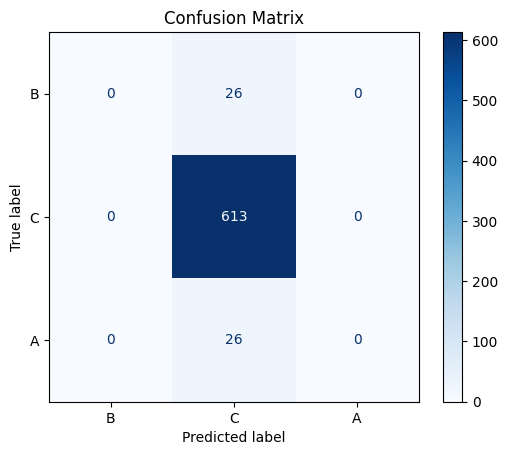




LR Classifier: 
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        26
           B       0.92      1.00      0.96       613
           C       0.00      0.00      0.00        26

    accuracy                           0.92       665
   macro avg       0.31      0.33      0.32       665
weighted avg       0.85      0.92      0.88       665



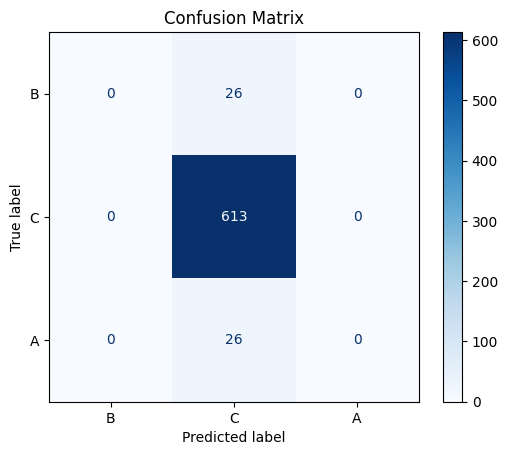




Voting Classifier: 
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        26
           B       0.92      1.00      0.96       613
           C       0.00      0.00      0.00        26

    accuracy                           0.92       665
   macro avg       0.31      0.33      0.32       665
weighted avg       0.85      0.92      0.88       665



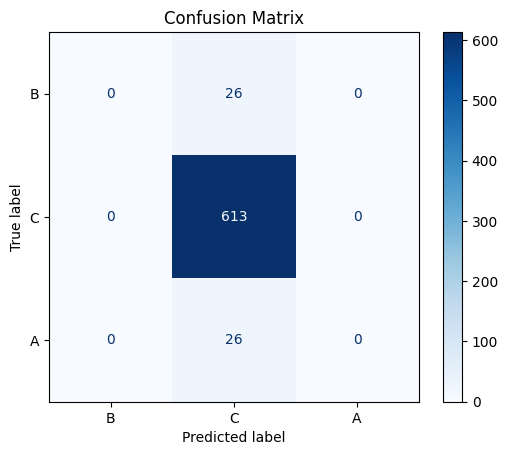

In [29]:
# Creating the models and adding them to the list
models = []
models.append(('SVM', SVC(C = 0.1, gamma = 'scale', kernel = 'linear')))
models.append(('LR', LogisticRegression(C = 0.1, max_iter = 100, multi_class = 'ovr', solver = 'newton-cg')))

# Creating the VotingClassifier
bases = []
model1 = LogisticRegression(C = 0.1, max_iter = 100, multi_class = 'ovr', solver = 'newton-cg')
bases.append(('lr', model1))
model2 = DecisionTreeClassifier(criterion ='gini', max_depth = 3, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2)
bases.append(('cart', model2))
model3 = SVC(C = 0.1, gamma = 'scale', kernel = 'linear')
bases.append(('svm', model3))

models.append(('Voting', VotingClassifier(bases)))

# Iteratively training each model
for name, model in models:
  print(f"{name} Classifier: ")
  # Train the model
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)

  # Show the overall report
  print(classification_report(y_test, y_pred))

  # Show Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)

  # Display confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.show()

  print("\n\n")

In [30]:
print(f'\tRuntime: {round((datetime.now()- runtime_start).total_seconds()/60,2)} minutes')

	Runtime: 5.64 minutes


## Conclusion
In the end, we found three models that can explain the data with the same performance: 92% accuracy and precision, and f1-score of 96%. Finally, we recommend any of these algorithms: Logistic Regression, Support Vector Machine and Voting Ensemble.

### Appendice: Is a Recurrent Neural Network better for this kind of problem?
Once our team showed articles about Deep Learning on Task 2, we decided to check if a LSTM will have a better accuracy hate. The Recurrent Neural Network is often better for complex problems than Machine Learning Algorithms, specially the LSTM when the problems is related to temporal series.

From this point on, the execution time is more than 3 hours to train, validate and test the LSTM with the best accuracy. Few minutes are needed to train, validate and test an RNN model, and most of the time is spent finding the best hyperparameters to obtain the best result.

In [31]:
runtime_start = datetime.now()
!pip install scikeras

In [32]:
# Adding the main libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

In [33]:
def create_sequences(X, y, time_step=30):
# Prepar the data to feed the LSTM
    X_seq = []
    y_seq = []
    for i in range(time_step, len(X)):
        X_seq.append(X[i-time_step:i, :])
        target = y[i]
        # Transform string categorical value into numeric one
        if target == 'A': target = -1
        elif target == 'B': target = 0
        else: target = 1
        y_seq.append(target)
    return np.array(X_seq), np.array(y_seq)


# Prepar the train, validation and test data
X_seq_train, y_seq_train = create_sequences(X_train.values, y_train.values, time_step=30)
X_seq_validation, y_seq_validation = create_sequences(X_validation.values, y_validation.values, time_step=30)
X_seq_test, y_seq_test = create_sequences(X_test.values, y_test.values, time_step=30)

# Create the RNN with 3 layers
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1, activation='sigmoid'))

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])
model.fit(X_seq_train, y_seq_train, epochs=30, batch_size=4096, validation_data=(X_seq_validation, y_seq_validation))

# Make Predictions
predicted_labels = model.predict(X_seq_test)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9557 - loss: 0.2490 - val_accuracy: 0.9396 - val_loss: 0.1867
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 448ms/step - accuracy: 0.9557 - loss: 0.1723 - val_accuracy: 0.9396 - val_loss: 0.1316
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - accuracy: 0.9557 - loss: 0.1170 - val_accuracy: 0.9396 - val_loss: 0.0944
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 600ms/step - accuracy: 0.9557 - loss: 0.0797 - val_accuracy: 0.9396 - val_loss: 0.0744
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 817ms/step - accuracy: 0.9559 - loss: 0.0594 - val_accuracy: 0.9396 - val_loss: 0.0658
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step - accuracy: 0.9555 - loss: 0.0509 - val_accuracy: 0.9396 - val_loss: 0.0625
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 401ms/step - accuracy: 0.9557 - loss: 0.0470 - val_accuracy: 0.9396 - val_loss: 0.0613
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step - accuracy: 0.9561 - loss: 0.0452 - val_accuracy: 0.9396 - val_loss: 0.

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        24
           0       0.92      1.00      0.96       586
           1       0.00      0.00      0.00        25

    accuracy                           0.92       635
   macro avg       0.31      0.33      0.32       635
weighted avg       0.85      0.92      0.89       635



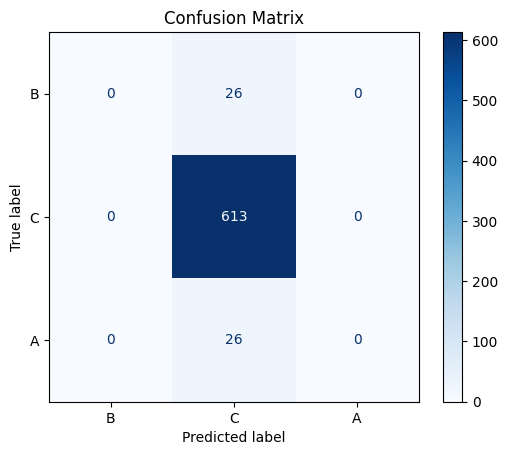

In [34]:
# Create the confusion matrix
predicted_labels = np.round(predicted_labels)

# Show the overall report
print(classification_report(y_seq_test, predicted_labels))

# Show Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

As we did for the Machine Learning algorithms, now we're finding out the best hyper-parameters to increase the accuracy hate, changing the following parameters of LSTM: units, return_sequences and activation.

The following steps need more than 3 hours to finish. During the tests, we saw that, after fine-tuning, the best results is equal to previous Machine Learning algoritms on accuracy and f1-score.

In [ ]:
# Function to create a lst_model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])))
    model.add(LSTM(units=50, return_sequences = False))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])
    return model

param_grid = {
    'epochs': [30, 50, 100, 200],
    'batch_size': [512, 1024, 2048, 4096]
}

# Method to create a LSTM neural network by function calling
model = KerasClassifier(build_fn=create_lstm_model, epochs=10, batch_size=512)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=7)
grid_result = grid.fit(X_seq_train, y_seq_train, validation_data=(X_seq_validation, y_seq_validation), verbose=0)

# Show the results
print("\n\nMelhores hiperparâmetros encontrados:")
print(grid_result.best_params_)
print("Acurácia média para os melhores hiperparâmetros:")
print(grid_result.best_score_)

# Make Predictions
predicted_labels = grid.predict(X_seq_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


In [ ]:
# Create the confusion matrix
predicted_labels = np.round(predicted_labels)

# Show the overall report
print(classification_report(y_seq_test, predicted_labels))

# Show Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(f'\tRuntime: {round((datetime.now() - runtime_start).total_seconds()/60,2)} minutes')

Finally, considering the execution time, processing resources and memory required, we recommend using those Machine Learning algorithms for this problem (in the configurations it is in) rather than LSTM: Logistic Regression, Support Vector Machine and Voting Ensemble.